## Imports

In [1]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import ast
import numpy as np
import torch.optim as optim

# Define and train siamese network

In [2]:
class SiameseNetwork(nn.Module):
    def __init__(self, input_size, embedding_size=128):
        super(SiameseNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, embedding_size),
        )
    
    def forward(self, x):
        x = self.fc(x)
        return x

In [3]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin
    
    def forward(self, anchor, positive, negative):
        distance_positive = (anchor - positive).pow(2).sum(1)
        distance_negative = (anchor - negative).pow(2).sum(1)
        losses = torch.relu(distance_positive - distance_negative + self.margin)
        return losses.mean()

In [4]:
class TripletFeatureDataset(Dataset):
    def __init__(self, df_dataset, df_blip):
        self.df_blip = df_blip.set_index('image_path')
        self.blip_vector_cache = {}
        
        print("start")
        self.anchor_paths = df_dataset['anchor'].values
        print('1')
        self.similar_paths = df_dataset['similar'].values
        print('2')
        self.dissimilar_paths = df_dataset['dissimilar'].values
        print('end')

    def __getitem__(self, index):
        anchor_vector = self.get_blip_vector(self.anchor_paths[index])
        positive_vector = self.get_blip_vector(self.similar_paths[index])
        negative_vector = self.get_blip_vector(self.dissimilar_paths[index])
  
        anchor = torch.FloatTensor(anchor_vector)
        positive = torch.FloatTensor(positive_vector)
        negative = torch.FloatTensor(negative_vector)
        
        return anchor, positive, negative
    
    def __len__(self):
        return len(self.anchor_paths)
    
    def get_blip_vector(self, img_path):
        if img_path in self.blip_vector_cache:
            return self.blip_vector_cache[img_path]
        
        vector = ast.literal_eval(self.df_blip.loc[img_path, 'blip'] if img_path in self.df_blip.index else np.nan)
        self.blip_vector_cache[img_path] = vector
        return vector


In [5]:
import os
import matplotlib.pyplot as plt

def save_model_weights(model, epoch, total_epoch, save_directory="model_weights"):
    directory_path = f"/kaggle/working/{save_directory}"
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)
    
    file_path = f"/kaggle/working/{save_directory}/model_{total_epoch}_epoch_{epoch}.pt"
    torch.save(model.state_dict(), file_path)


def plot_loss(all_losses, current_epoch, total_epochs, save_directory="loss_plots", show=True):
    plt.figure(figsize=(10, 6))
    steps = range(1, len(all_losses) + 1)
    plt.plot(steps, all_losses, label='Loss per Step')
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.title(f'Loss per Step up to Epoch {current_epoch}/{total_epochs}')
    plt.legend()
    plt.grid(True)
    
    directory_path = f"/kaggle/working/{save_directory}"
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)
    
    plt.savefig(f"{directory_path}/loss_per_step_up_to_epoch_{current_epoch}.png")
    
    if show:
        plt.show()
    plt.close()


## Load reduced training triplets dataset for tuning

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset_path = '/kaggle/input/new-cds-triplets/reduced_training_triplets.csv'
dataset_blip_path = '/kaggle/input/new-cds-triplets-images/reduced_training_with_blip.csv'

df_testing_triplets = pd.read_csv(dataset_path)
df_testing_blip = pd.read_csv(dataset_blip_path)

In [7]:
EPOCHS = 5
BATCH_SIZE=512
weights_path = None

## Train

start
1
2
end


Epoch 1/5: 100%|██████████| 951/951 [03:54<00:00,  4.06it/s, loss=0.847]


Epoch 1, Average Loss: 0.8509783125575534
Epoch 1 done saving weights


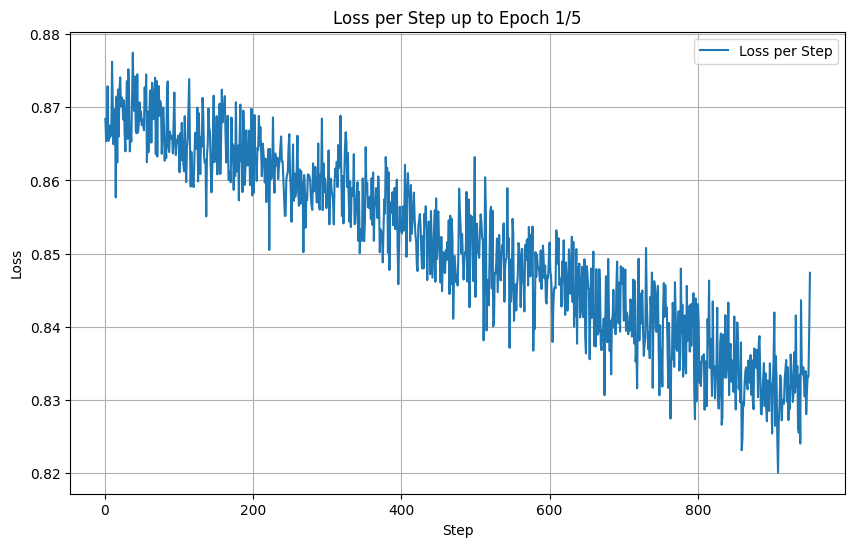

Epoch 2/5: 100%|██████████| 951/951 [03:45<00:00,  4.21it/s, loss=0.797]


Epoch 2, Average Loss: 0.8266458823477808
Epoch 2 done saving weights


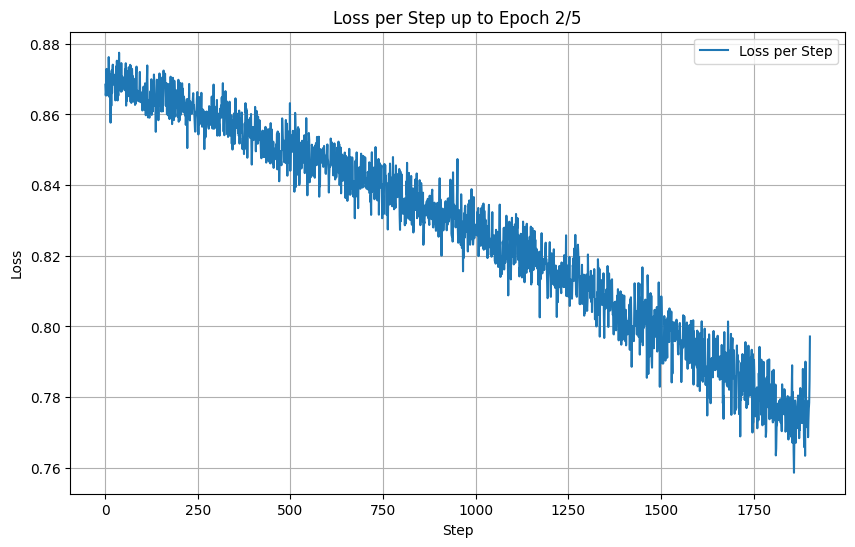

Epoch 3/5: 100%|██████████| 951/951 [03:46<00:00,  4.20it/s, loss=0.727]


Epoch 3, Average Loss: 0.7956417008027921
Epoch 3 done saving weights


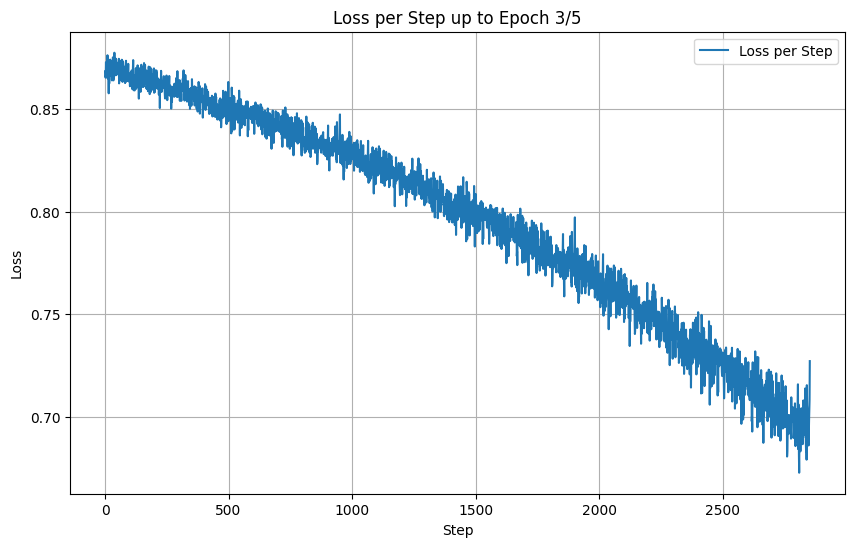

Epoch 4/5: 100%|██████████| 951/951 [03:45<00:00,  4.21it/s, loss=0.637]


Epoch 4, Average Loss: 0.7570294806445811
Epoch 4 done saving weights


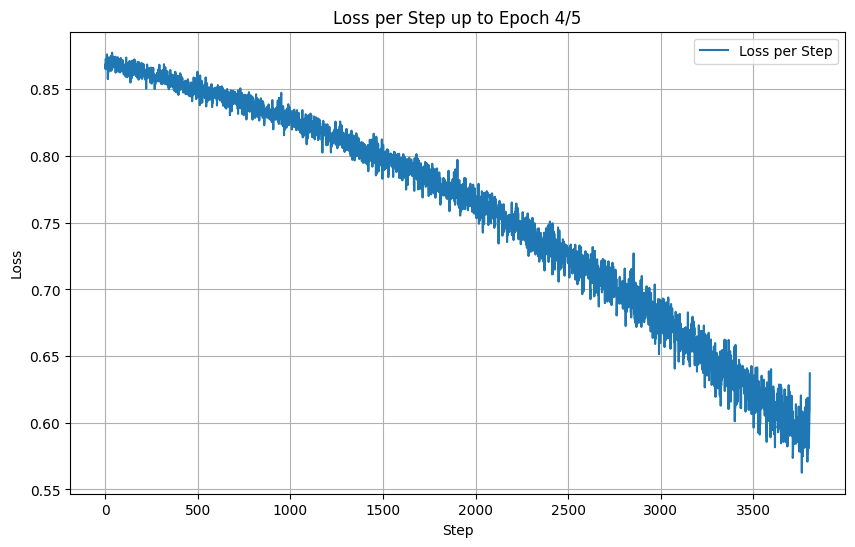

Epoch 5/5: 100%|██████████| 951/951 [03:46<00:00,  4.19it/s, loss=0.552]


Epoch 5, Average Loss: 0.7138750260435319
Epoch 5 done saving weights


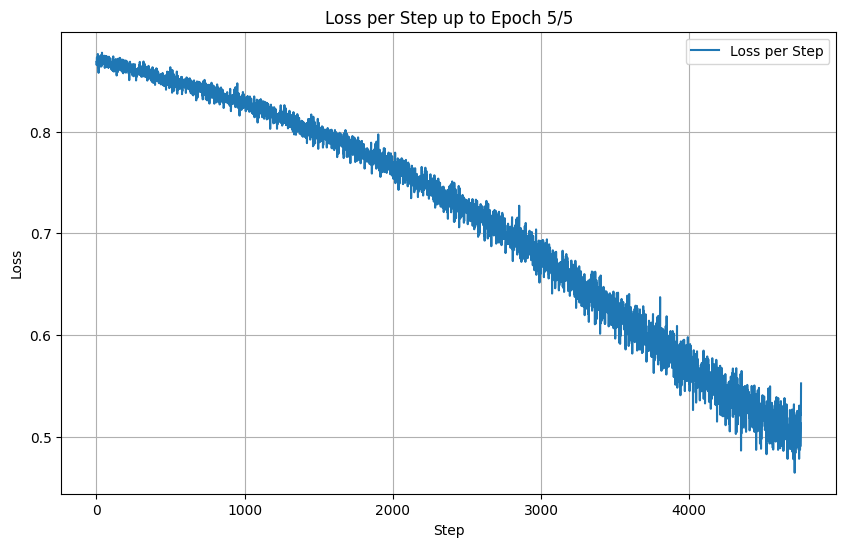

In [8]:
from tqdm import tqdm

# update: blip output size is 768
siamese_model = SiameseNetwork(input_size=768, embedding_size=128).to(device)

# load weights if present
if weights_path:
    siamese_model.load_state_dict(torch.load(weights_path, map_location=device))
    
siamese_model.train()
criterion = TripletLoss(margin=1.0)
optimizer = optim.Adam(siamese_model.parameters(), lr=0.0000001)

total_loss = 0 # To track loss over the entire training
losses = []  # To store loss at each step or at save intervals

test_dataset = TripletFeatureDataset(df_testing_triplets, df_testing_blip)#to remove index
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

for epoch in range(EPOCHS):
    
    progress_bar = tqdm(enumerate(test_dataloader), total=len(test_dataloader), desc=f"Epoch {epoch+1}/{EPOCHS}")
    
    for i, data in progress_bar:
        anchor, positive, negative = data
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

        optimizer.zero_grad()

        anchor_output = siamese_model(anchor)
        positive_output = siamese_model(positive)
        negative_output = siamese_model(negative)

        loss = criterion(anchor_output, positive_output, negative_output)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        losses.append(loss.item())
        
        progress_bar.set_postfix(loss=loss.item())

    print(f"Epoch {epoch+1}, Average Loss: {sum(losses)/len(losses)}")
    save_model_weights(siamese_model, epoch, EPOCHS)
    print(f'Epoch {epoch+1} done saving weights')
    plot_loss(losses, epoch+1, EPOCHS)
    